In [1]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

# 출력값 초기화
from google.colab import output
output.clear()

# 경로 수정
import os
os.chdir("drive/MyDrive/Colab Notebooks/가스공급량 수요예측 모델개발")

In [2]:
# import libary
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os, glob, sys
import matplotlib.pyplot as plt

train_csv = pd.read_csv("./datasets/한국가스공사_시간별 공급량.csv", encoding = 'cp949', engine='python')

# test_csv 파일 전처리
test_csv = pd.read_csv("./datasets/test.csv", encoding = 'utf-8')

test_date = []
test_hour = []
test_class = []

for component in test_csv.values:
    string = component.item()
    test_date.append(string.split(" ")[0])
    test_hour.append(string.split(" ")[1])
    test_class.append(string.split(" ")[-1])

test_csv = pd.DataFrame({'연월일':test_date, "시간":test_hour, "구분":test_class})
sample_submission = pd.read_csv("./datasets/sample_submission.csv", encoding = "utf-8")

In [3]:
# rename column
train_csv.rename(columns = {'연월일' : 'time', "시간":"hour", "구분":"class", "공급량":"power"}, inplace = True)

In [4]:
# rename column
test_csv.rename(columns = {'연월일' : 'time', "시간":"hour", "구분":"class"}, inplace = True)

In [5]:
# 자료형 변환
from datetime import datetime

# time : str to datetime
try:
    train_csv["time"] = train_csv["time"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
    test_csv["time"] = test_csv["time"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
except:
    print("data type of time not str or already converted")

# hour : str to int

try:
    test_csv["hour"] = test_csv["hour"].apply(lambda x : int(x))
except:
    print("data type of hour not str or already converted")

In [6]:
# time - hour => timestamp with yyyy-mm-dd-hh
import datetime

def df_time_convert(df):
    df_copy = df.copy(...)
    timestamp_list = []
    for idx in range(len(df)):
        timestamp_list.append(df_copy.time.iloc[idx] + datetime.timedelta(hours = df_copy.hour.iloc[idx].item()))
    df_copy["time"] = timestamp_list
    return df_copy

# class에 따른 데이터프레임 분류
def df_class_split(df, cls = "A"):
    df_copy = df.copy(...)
    df_copy = df_copy[df_copy["class"] == cls]
    return df_copy

# class to idx
def class_to_idx(x):
    dic = {'A':0,"B":1,"C":2,"D":3,'E':4,'G':5,"H":6}
    if type(x) == str:
        try:
            return_value = int(dic[x])
        except:
            return_value = 0
            print("didn't find class {}".format(x))

    else:
        return_value = 0
    
    return return_value

# convert original scale to log scale
def convert2log(x):
    eps = 1e-6
    if abs(x) < eps:
        return NaN
    else:
        return np.log1p(x)
    
def convert2origin(x):
    return np.exp(x) - 1

In [7]:
# External Data(weather)
import glob2
import datetime

path_list_external_weather = glob2.glob("./dataset_external_weather/*")
print(path_list_external_weather)

df_weather = None
for idx, path in enumerate(path_list_external_weather):

    if idx == 0:
        df_weather = pd.read_csv(path, encoding = "cp949")
    else:
        df_temp = pd.read_csv(path, encoding = "cp949")
        df_weather = pd.concat([df_weather, df_temp], axis = 0)


# column name change
df_weather.rename(columns = {"일시": "date_time","기온(°C)" : "temperature", "습도(%)":"humidity", "증기압(hPa)" : "vapor", "현지기압(hPa)":"pressure", "풍속(m/s)":"wind_speed"}, inplace = True)

df_weather["date_time"] = df_weather["date_time"].apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%d %H:%M" ))

# 결측치 보완
df_weather["temperature"] = df_weather["temperature"].interpolate(method = "values")
df_weather["humidity"] = df_weather["humidity"].interpolate(method = "values")
df_weather["vapor"] = df_weather["vapor"].interpolate(method = "values")
df_weather["wind_speed"] = df_weather["wind_speed"].interpolate(method = "values")
df_weather["pressure"] = df_weather["pressure"].interpolate(method = "values")

# merge
df = train_csv.copy()
df = df_time_convert(df)
df["class"] = df["class"].apply(lambda x : int(class_to_idx(x)))

df_merge = pd.merge(left = df, right = df_weather[["date_time", "temperature", "humidity", "vapor", "pressure", "wind_speed"]], how = 'outer', left_on = "time", right_on = "date_time")
df_merge = df_merge.drop(columns = ['date_time'], axis = 1)

['./dataset_external_weather/OBS_ASOS_TIM_20211017003024.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017003117.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004006.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004047.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004154.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004224.csv']


In [8]:
df_merge = df_merge.dropna()

In [9]:
# anomality annhiliation
# 우선 class별로 분포가 다르므로, class에 따라 묶어서 anomality annhiliation을 진행한다
class_list = np.unique(train_csv["class"].values).tolist()
df_list = [df_class_split(df_merge, cls = i).sort_values(by = ["time"]) for i in range(len(class_list))]

# 데이터 구분
# df_list : class별로 나눈 데이터
# df_merge : 외부데이터까지 하나로 합친 데이터

# range and length analysis
idx_to_class = ['A', 'B','C', 'D', "E", 'G', 'H']
for idx, df in enumerate(df_list):
    print("class : {}, length : {}, start time : {}, end time : {}".format(
        idx_to_class[idx],
        len(df),
        df['time'].iloc[0],
        df['time'].iloc[-1]
    ))

class : A, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : B, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : C, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : D, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : E, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : G, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : H, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00


In [10]:
# 이상치 제거
def remove_outlier(df_input, column):
    df = df_input.copy(...)
    df_removed_column_outlier = df[column]
    quan_25 = np.percentile(df_removed_column_outlier.values, 25)
    quan_75 = np.percentile(df_removed_column_outlier.values, 75)

    iqr = quan_75 - quan_25
    iqr = iqr * 1.5

    lowest = quan_25 - iqr
    highest = quan_75 + iqr

    outlier_index = df_removed_column_outlier[(df_removed_column_outlier < lowest) | (df_removed_column_outlier > highest)].index
    
    if len(outlier_index) > 0:
        print("# outlier detected")
        df.drop(outlier_index, axis = 0, inplace = True)
    else:
        print("# outlier not detected")
        pass

    return df

df_list_new = []
for df in df_list:
    df = remove_outlier(df, "power")
    df_list_new.append(df)

df_list = df_list_new

idx_to_class = ['A', 'B','C', 'D', "E", 'G', 'H']
for idx, df in enumerate(df_list):
    print("class : {}, length : {}, start time : {}, end time : {}".format(
        idx_to_class[idx],
        len(df),
        df['time'].iloc[0],
        df['time'].iloc[-1]
    ))

# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
class : A, length : 52231, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : B, length : 52300, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : C, length : 52308, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : D, length : 52439, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : E, length : 52332, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : G, length : 52214, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : H, length : 52352, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00


In [11]:
# 0인 이상치도 제거...
df_list_new = []
for df in df_list:
    index_list = df["power"].values >= 10
    df = df.iloc[index_list]
    df_list_new.append(df)

df_list = df_list_new

In [12]:
# 최종적으로 쓸 dataframe
# df_list를 모두 합친 데이터프레임
df = None

for df_class in df_list:
    if df is None:
        df = df_class
    else:
        df = pd.concat([df, df_class], axis = 0)

display(df)

,time,hour,class,power,temperature,humidity,vapor,pressure,wind_speed
0,2013-01-01 01:00:00,1.0,0.0,2497.129,-8.5,57.0,1.8,1010.0,4.0
7,2013-01-01 02:00:00,2.0,0.0,2363.265,-8.4,60.0,2.0,1009.4,4.0
14,2013-01-01 03:00:00,3.0,0.0,2258.505,-8.1,58.0,1.9,1009.2,3.4
21,2013-01-01 04:00:00,4.0,0.0,2243.969,-8.2,58.0,1.9,1008.2,3.8
28,2013-01-01 05:00:00,5.0,0.0,2344.105,-8.2,61.0,2.0,1007.3,4.4
...,...,...,...,...,...,...,...,...,...
368059,2018-12-31 20:00:00,20.0,6.0,681.033,-3.7,39.0,1.8,1024.9,0.8
368066,2018-12-31 21:00:00,21.0,6.0,669.961,-4.6,44.0,1.9,1024.8,1.1
368073,2018-12-31 22:00:00,22.0,6.0,657.941,-5.4,46.0,1.9,1024.4,1.3
368080,2018-12-31 23:00:00,23.0,6.0,610.953,-5.2,47.0,2.0,1024.6,1.6


In [13]:
# year / month / day -> sinusoidal value
day = 24 * 60 * 60
month = (30.0) * day
year = (365.2425)*day

df["month_cos"] = np.cos(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))
df["month_sin"] = np.sin(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))

df["year_cos"] = np.cos(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))
df["year_sin"] = np.sin(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))

df["day_cos"] = np.cos(df.hour.values * (2 * np.pi / 24))
df["day_sin"] = np.sin(df.hour.values * (2 * np.pi / 24))

output.clear()

In [14]:
# 공휴일 유무에 대한 categorical variable 추가
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = df['time']

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
df['holiday'] = df['time'].isin(cal.holidays())

In [15]:
# categorical variable로 전환
df["class"] = df["class"].astype("category")
df["class"] = df["class"].apply(lambda x : int(x))

df['holiday'] = df['holiday'].astype('category')
df['holiday'] = df['holiday'].apply(lambda x : int(x))

In [16]:
# log-scale 처리된 power 값 추가
df["log_power"] = df["power"].apply(lambda x : convert2log(x))

In [17]:
# test data의 경우 1월 - 3월까지만 예측
# 1월 - 3월까지의 데이터만 따로 선별해보자
# test data : 2018년 1월 - 3월 데이터
# train data : 2018년을 제외한 나머지 데이터
df_train = None

for class_idx in range(len(class_list)):

    train_idx_list = []
    df_class = df[df["class"] == class_idx]

    for idx in range(len(df_class)):
        y = df_class['time'].iloc[idx].year
        m = df_class['time'].iloc[idx].month

        if y != 2018:
            train_idx_list.append(idx)

    df_train_class = df_class.iloc[train_idx_list]

    if df_train is None:
        df_train = df_train_class
    else:
        df_train = pd.concat([df_train, df_train_class], axis = 0)

# build test data
df_test = None

for class_idx in range(len(class_list)):
    df_class = df[df["class"] == class_idx]
    test_idx_list = []

    for idx in range(len(df_class)):
        y = df_class['time'].iloc[idx].year
        m = df_class['time'].iloc[idx].month

        if y == 2018 and m in [1,2,3]:
            test_idx_list.append(idx)

    df_test_class = df_class.iloc[test_idx_list]

    if df_test is None:
        df_test = df_test_class
    else:
        df_test = pd.concat([df_test, df_test_class], axis = 0)

In [18]:
def calc_nmae(y_test, y_pred):
    score = np.mean((np.abs((y_test - y_pred)/y_test)))
    return score

In [19]:
!pip install catboost
output.clear()

In [45]:
# k-fold stacking ensemble without supervised learning(series to supervised)
#from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor

# columns for use
x_cols = ["year_cos", "year_sin", "month_cos", "month_sin", "day_cos", "day_sin", "class", "holiday"]
y_cols = ["log_power"]

# k-fold validation
num_k = len(class_list)
k_fold = StratifiedKFold(n_splits = num_k, shuffle = True, random_state = 42)

x_train, y_train = df_train[x_cols], df_train[y_cols]
x_test, y_test = df_test[x_cols], df_test[y_cols]

y_train_origin, y_test_origin = df_train[["power"]], df_test[["power"]]

In [24]:
# for lgbm
import lightgbm as lgb

esr = 400 
nbr = 100

lgb_params = {
    "boosting_type":"dart", # gbdt, rf, dart, goss
    "num_leaves":64,
    "max_depth":32,
    "learning_rate":0.5,
    "objective":"regression",
    "n_estimators":128,
    "subsample_for_bin":250000,
    "min_split_gain":0.7,
    "min_child_weight":1e-3,
    "min_child_samples":20,
    "subsample":1.0,
    "subsample_freq":0,
    "colsample_bytree":1.0,
    "reg_alpha":0.1,
    "reg_lambda":0.1,
    "n_jobs":-1,
    "metric":"mse",
    "num_threads" : 8,
}

# custom metric for lgbm
def custom_metric(y_pred, dataset):
    y_true = dataset.get_label().reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    eps = 1e-3
    score = np.mean((np.abs(y_true - y_pred)) / (y_true + eps))
    return 'custom_metric score', score, False


# training process with stacking ensemble
preds = []
preds_test = []
val_idxs = []
model_lgb_list = []

for idx, (tr_idx, val_idx) in enumerate(k_fold.split(x_train, x_train['class'])):

    tr_x, val_x = x_train.iloc[tr_idx], x_train.iloc[val_idx]
    tr_y, val_y = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    train_data = lgb.Dataset(tr_x, tr_y)
    valid_data = lgb.Dataset(val_x, val_y)
    test_data = lgb.Dataset(x_test, y_test)

    model = lgb.train(lgb_params, train_data, valid_sets = valid_data, num_boost_round = nbr, early_stopping_rounds = esr)
    model_lgb_list.append(model)

    pred = model.predict(val_x)
    val_idxs.append(val_idx)
    pred = np.array([convert2origin(x) for x in pred])

    preds.append(pred)

    pred_test = model.predict(x_test)
    pred_test = np.array([convert2origin(x) for x in pred_test])
    preds_test.append(pred_test)

preds = np.concatenate(preds, axis = 0)
val_idxs = np.concatenate(val_idxs)
order = np.argsort(val_idxs)
preds_train_lgb = preds[order]
preds_test_lgb = np.mean(preds_test, axis = 0)

train_score = calc_nmae(y_train_origin.values.reshape(-1,1), preds_train_lgb.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), preds_test_lgb.reshape(-1,1))

print("# lgbm stacking ensemble train_score : {:.3f}".format(train_score))
print("# lgbm stacking ensemble test_score : {:.3f}".format(test_score))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[1]	valid_0's l2: 0.353593
[2]	valid_0's l2: 0.130743
[3]	valid_0's l2: 0.0675083
[4]	valid_0's l2: 0.0484102
[5]	valid_0's l2: 0.0414416
[6]	valid_0's l2: 0.0380798
[7]	valid_0's l2: 0.0326574
[8]	valid_0's l2: 0.0362814
[9]	valid_0's l2: 0.0314008
[10]	valid_0's l2: 0.0283637
[11]	valid_0's l2: 0.0268706
[12]	valid_0's l2: 0.0273144
[13]	valid_0's l2: 0.0261057
[14]	valid_0's l2: 0.0253565
[15]	valid_0's l2: 0.0243398
[16]	valid_0's l2: 0.0225422
[17]	valid_0's l2: 0.0223733
[18]	valid_0's l2: 0.0223189
[19]	valid_0's l2: 0.0222914
[20]	valid_0's l2: 0.0222857
[21]	valid_0's l2: 0.0222375
[22]	valid_0's l2: 0.0221336
[23]	valid_0's l2: 0.0220198
[24]	valid_0's l2: 0.0208433
[25]	valid_0's l2: 0.0208268
[26]	valid_0's l2: 0.0208268
[27]	valid_0's l2: 0.0208268
[28]	valid_0's l2: 0.0209213
[29]	valid_0's l2: 0.0209195
[30]	valid_0's l2: 0.0209091
[31]	valid_0's l2: 0.0209051
[32]	valid_0's l2: 0.0209051
[33]	valid_0's l2: 0.0208843
[34]	valid_0's l2: 0.0208843
[35]	valid_0's l2: 0.0208

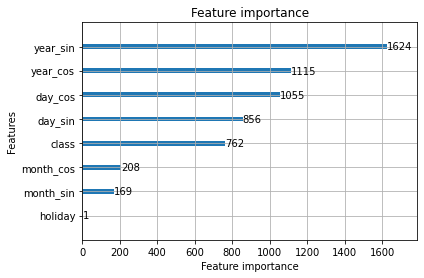

In [25]:
# plot importance
lgb.plot_importance(model)

In [48]:
# for xgboost
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error

esr = 400 
nbr = 100

xgb_params = {
    "boosting_type":"dart", 
    "num_leaves":64,
    "max_depth":32,
    "learning_rate":0.5,
    "n_estimators":128,
    "subsample_for_bin":250000,
    "min_split_gain":0.7,
    "min_child_weight":1e-3,
    "min_child_samples":20,
    "subsample":1.0,
    "subsample_freq":0,
    "colsample_bytree":1.0,
    "reg_alpha":0.1,
    "reg_lambda":0.1,
    "n_jobs":-1,
    "metric":"mse",
    "num_threads" : 8,
    "enable_categorical":True,
    "use_label_encoder":False,
}

# custom metric for xgb
def custom_metric(y_pred, dataset):
    y_true = dataset.get_label()
    y_pred = y_pred
    eps = 1e-3
    score = np.mean((np.abs(y_true - y_pred)) / (y_true + eps))
    return 'custom_metric score', score

# training process with stacking ensemble
preds = []
preds_test = []
val_idxs = []
model_xgb_list = []

# categorical variable => int 형으로 변환
x_train["class"] = x_train["class"].astype("int")
x_train['holiday'] = x_train['holiday'].astype('int')

x_test["class"] = x_test["class"].astype("int")
x_test['holiday'] = x_test['holiday'].astype('int')

for idx, (tr_idx, val_idx) in enumerate(k_fold.split(x_train, x_train['class'])):

    tr_x, val_x = x_train.iloc[tr_idx], x_train.iloc[val_idx]
    tr_y, val_y = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    train_data = xgb.DMatrix(tr_x, tr_y)
    valid_data = xgb.DMatrix(val_x, val_y)
    test_data = xgb.DMatrix(x_test, y_test)

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(tr_x, tr_y, early_stopping_rounds = esr, eval_set = [(val_x, val_y)])
    model_xgb_list.append(model)

    pred = model.predict(val_x)
    val_idxs.append(val_idx)
    pred = np.array([convert2origin(x) for x in pred])

    preds.append(pred)

    pred_test = model.predict(x_test)
    pred_test = np.array([convert2origin(x) for x in pred_test])
    preds_test.append(pred_test)

preds = np.concatenate(preds, axis = 0)
val_idxs = np.concatenate(val_idxs)
order = np.argsort(val_idxs)
preds_train_xgb = preds[order]
preds_test_xgb = np.mean(preds_test, axis = 0)


train_score = calc_nmae(y_train_origin.values.reshape(-1,1), preds_train_xgb.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), preds_test_xgb.reshape(-1,1))

print("# xgb stacking ensemble train_score : {:.3f}".format(train_score))
print("# xgb stacking ensemble test_score : {:.3f}".format(test_score))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

[07:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.97006
Will train until validation_0-rmse hasn't improved in 400 rounds.
[1]	validation_0-rmse:1.49257
[2]	validation_0-rmse:0.758033
[3]	validation_0-rmse:0.395041
[4]	validation_0-rmse:0.219163
[5]	validation_0-rmse:0.137456
[6]	validation_0-rmse:0.100015
[7]	validation_0-rmse:0.083024
[8]	validation_0-rmse:0.074667
[9]	validation_0-rmse:0.071094
[10]	validation_0-rmse:0.067838
[11]	validation_0-rmse:0.066562
[12]	validation_0-rmse:0.065418
[13]	validation_0-rmse:0.064868
[14]	validation_0-rmse:0.064222
[15]	validation_0-rmse:0.063957
[16]	validation_0-rmse:0.063621
[17]	validation_0-rmse:0.063331
[18]	validation_0-rmse:0.063135
[19]	validation_0-rmse:0.063035
[20]	validation_0-rmse:0.062862
[21]	validation_0-rmse:0.06267
[22]	validation_0-rmse:0.062498
[23]	validation_0-rmse:0.062416
[24]	validation_0-rmse:0.062384
[25]	validation_0-rm

In [26]:
# for catboost
cb_features = df_train.columns[df_train.dtypes == 'category'].to_list()

# custom eval metric
class CatboostCustomMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        preds = np.array(approxes[0])
        target = np.array(target)
        error = np.mean((np.abs(target - preds)) / (target + eps))
        return error, 0

cb_params = {
    "iterations" : 256,
    "learning_rate" : 0.3,
    "task_type" : "GPU",
    "loss_function" : "MAPE", 
    "max_depth" : 16,
}

x_train["class"] = x_train["class"].astype("category")
x_train['holiday'] = x_train['holiday'].astype('category')

x_test["class"] = x_test["class"].astype("category")
x_test['holiday'] = x_test['holiday'].astype('category')

preds = []
preds_test = []
val_idxs = []
model_cbr_list = []

for idx, (tr_idx, val_idx) in enumerate(k_fold.split(x_train, x_train['class'])):

    tr_x, val_x = x_train.iloc[tr_idx], x_train.iloc[val_idx]
    tr_y, val_y = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    model = CatBoostRegressor(**cb_params)
    model.fit(tr_x, tr_y, eval_set = (val_x, val_y), cat_features=cb_features)
    model_cbr_list.append(model)

    pred = model.predict(val_x)
    val_idxs.append(val_idx)
    pred = np.array([convert2origin(x) for x in pred])

    preds.append(pred)

    pred_test = model.predict(x_test)
    pred_test = np.array([convert2origin(x) for x in pred_test])
    preds_test.append(pred_test)

preds = np.concatenate(preds, axis = 0)
val_idxs = np.concatenate(val_idxs)
order = np.argsort(val_idxs)
preds_train_cbc = preds[order]
preds_test_cbc = np.mean(preds_test, axis = 0)

train_score = calc_nmae(y_train_origin.values.reshape(-1,1), preds_train_cbc.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), preds_test_cbc.reshape(-1,1))

print("# Catboost stacking ensemble train_score : {:.3f}".format(train_score))
print("# Catboost stacking ensemble test_score : {:.3f}".format(test_score))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

0:	learn: 0.1117773	test: 0.1119317	best: 0.1119317 (0)	total: 292ms	remaining: 1m 14s
1:	learn: 0.0806452	test: 0.0808220	best: 0.0808220 (1)	total: 571ms	remaining: 1m 12s
2:	learn: 0.0586495	test: 0.0588437	best: 0.0588437 (2)	total: 775ms	remaining: 1m 5s
3:	learn: 0.0436352	test: 0.0439210	best: 0.0439210 (3)	total: 1.06s	remaining: 1m 6s
4:	learn: 0.0338117	test: 0.0341722	best: 0.0341722 (4)	total: 1.35s	remaining: 1m 7s
5:	learn: 0.0277989	test: 0.0282241	best: 0.0282241 (5)	total: 1.63s	remaining: 1m 8s
6:	learn: 0.0239837	test: 0.0244989	best: 0.0244989 (6)	total: 1.92s	remaining: 1m 8s
7:	learn: 0.0216870	test: 0.0223041	best: 0.0223041 (7)	total: 2.21s	remaining: 1m 8s
8:	learn: 0.0202535	test: 0.0209625	best: 0.0209625 (8)	total: 2.51s	remaining: 1m 8s
9:	learn: 0.0192352	test: 0.0199996	best: 0.0199996 (9)	total: 2.79s	remaining: 1m 8s
10:	learn: 0.0185134	test: 0.0192950	best: 0.0192950 (10)	total: 3.08s	remaining: 1m 8s
11:	learn: 0.0179400	test: 0.0187542	best: 0.01875

In [21]:
# neural prophet
!pip install git+https://github.com/ourownstory/neural_prophet.git
output.clear()

In [22]:
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet.benchmark import Dataset, NeuralProphetModel, ProphetModel
from neuralprophet.benchmark import SimpleBenchmark, CrossValidationBenchmark

model_prophet_list = [NeuralProphet() for _ in range(len(class_list))]

pred_train_list = []
pred_test_list = []

for cls, model in zip(class_list, model_prophet_list):
    df_class = df_train[df_train["class"] == class_to_idx(cls)]

    df_input = pd.DataFrame()
    df_input['ds'] = df_class['time']
    df_input['y'] = df_class['log_power']

    loss = model.fit(df_input, freq = 'H')
    pred_train = model.predict(df_input)['yhat1'].values
    pred_train = np.array([convert2origin(x) for x in pred_train])
    pred_train_list.append(pred_train)

    df_pred = pd.DataFrame()
    df_pred['ds'] = df_test[df_test["class"] == class_to_idx(cls)]['time'].reset_index(drop = True)
    df_pred['y'] = np.array([None for _ in range(len(df_pred))])
    pred_test = model.predict(df_pred)['yhat1'].values
    pred_test = np.array([convert2origin(x) for x in pred_test])
    pred_test_list.append(pred_test)

output.clear()

In [23]:
# evaluation
for cls, pred_train, pred_test in zip(class_list, pred_train_list, pred_test_list):

    train_actual = df_train[df_train["class"] == class_to_idx(cls)]["power"].values.reshape(-1,1)
    test_actual = df_test[df_test["class"] == class_to_idx(cls)]["power"].values.reshape(-1,1)

    train_score = calc_nmae(train_actual, pred_train.reshape(-1,1))
    test_score = calc_nmae(test_actual, pred_test.reshape(-1,1))
    
    print("# Neural Prophet train score:{:.3f} with class :{}".format(train_score, cls))
    print("# Neural Prophet test score:{:.3f} with class :{}".format(test_score, cls))

# Neural Prophet train score:0.174 with class :A
# Neural Prophet test score:0.229 with class :A
# Neural Prophet train score:0.212 with class :B
# Neural Prophet test score:0.235 with class :B
# Neural Prophet train score:0.109 with class :C
# Neural Prophet test score:0.174 with class :C
# Neural Prophet train score:0.179 with class :D
# Neural Prophet test score:0.191 with class :D
# Neural Prophet train score:0.177 with class :E
# Neural Prophet test score:0.224 with class :E
# Neural Prophet train score:0.121 with class :G
# Neural Prophet test score:0.142 with class :G
# Neural Prophet train score:0.207 with class :H
# Neural Prophet test score:0.214 with class :H


In [33]:
preds_train_prophet = None
preds_test_prophet = None
for pred_train, pred_test in zip(pred_train_list, pred_test_list):

    if preds_train_prophet is None:
        preds_train_prophet = pred_train
    else:
        preds_train_prophet = np.concatenate((preds_train_prophet, pred_train), axis = 0)

    if preds_test_prophet is None:
        preds_test_prophet = pred_test
    else:
        preds_test_prophet = np.concatenate((preds_test_prophet, pred_test), axis = 0)

In [36]:
train_score = calc_nmae(y_train_origin.values.reshape(-1,1), preds_train_prophet.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), preds_test_prophet.reshape(-1,1))

print("# Neural Prophet train score:{:.3f}".format(train_score))
print("# Neural Prophet test score:{:.3f}".format(test_score))

# Neural Prophet train score:0.169
# Neural Prophet test score:0.201


In [35]:
# average
pred_train_average = (preds_train_lgb + preds_train_xgb + preds_train_cbc + preds_train_prophet)/4
pred_test_average = (preds_test_lgb + preds_test_xgb + preds_test_cbc + preds_test_prophet) / 4

train_score = calc_nmae(y_train_origin.values.reshape(-1,1), pred_train_average.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), pred_test_average.reshape(-1,1))

print("# stacking ensemble train_score : {:.3f}".format(train_score))
print("# stacking ensemble test_score : {:.3f}".format(test_score))

# stacking ensemble train_score : 0.071
# stacking ensemble test_score : 0.143


In [39]:
# average without prophet
# 성능이 떨어지더라도 average ensemble로 전체 loss가 감소할 수 있다. 
pred_train_average = (preds_train_lgb + preds_train_xgb + preds_train_cbc )/3
pred_test_average = (preds_test_lgb + preds_test_xgb + preds_test_cbc ) / 3

train_score = calc_nmae(y_train_origin.values.reshape(-1,1), pred_train_average.reshape(-1,1))
test_score = calc_nmae(y_test_origin.values.reshape(-1,1), pred_test_average.reshape(-1,1))

print("# stacking ensemble train_score : {:.3f}".format(train_score))
print("# stacking ensemble test_score : {:.3f}".format(test_score))

# stacking ensemble train_score : 0.055
# stacking ensemble test_score : 0.145


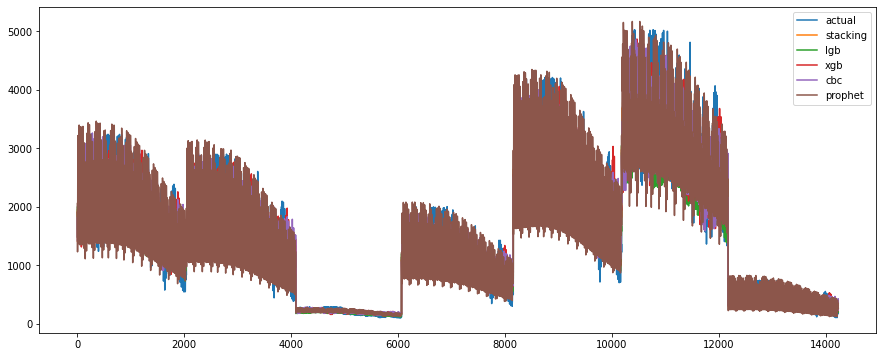

In [38]:
plt.figure(figsize = (15, 6))
plt.plot(y_test_origin.values, label = "actual")
plt.plot(pred_test_average, label = "stacking")
plt.plot(preds_test_lgb, label = "lgb")
plt.plot(preds_test_xgb, label = "xgb")
plt.plot(preds_test_cbc, label = "cbc")
plt.plot(preds_test_prophet, label = "prophet")
plt.legend()
plt.show()

In [40]:
# submission
idx_to_class = ['A','B','C','D',"E",'G','H']

df_submission = test_csv.copy()
df_submission = df_time_convert(df_submission)

df_submission['class'] = df_submission['class'].apply(lambda x : class_to_idx(x))
df_submission['class'] = df_submission['class'].astype("category")

df_submission["month_cos"] = np.cos(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))
df_submission["month_sin"] = np.sin(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))

df_submission["year_cos"] = np.cos(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))
df_submission["year_sin"] = np.sin(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))

df_submission["day_cos"] = np.cos(df_submission.hour.values * (2 * np.pi / 24))
df_submission["day_sin"] = np.sin(df_submission.hour.values * (2 * np.pi / 24))

# 공휴일 유무에 대한 categorical variable 추가
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = df_submission['time']

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
df_submission['holiday'] = df_submission['time'].isin(cal.holidays())

# categorical variable로 전환
df_submission["class"] = df_submission["class"].astype("category")
df_submission["class"] = df_submission["class"].apply(lambda x : int(x))

df_submission['holiday'] = df_submission['holiday'].astype('category')
df_submission['holiday'] = df_submission['holiday'].apply(lambda x : int(x))

output.clear()

In [50]:
x_cols = ["year_cos", "year_sin", "month_cos", "month_sin", "day_cos", "day_sin", "class", "holiday"]

x_submission = df_submission[x_cols]

preds_submission_lgb = []
preds_submission_xgb = []
preds_submission_cbr = []
preds_submission_prophet = []

# lgbm prediction
for model in model_lgb_list:
    pred = model.predict(x_submission)
    pred = np.array([convert2origin(x) for x in pred])
    preds_submission_lgb.append(pred)

# catboost prediction
for model in model_cbr_list:
    pred = model.predict(x_submission)
    pred = np.array([convert2origin(x) for x in pred])
    preds_submission_cbr.append(pred)

# xgb : 형 변환
x_submission['class'] = x_submission['class'].astype('int')
x_submission['holiday'] = x_submission['holiday'].astype('int')

# xgboost prediction
for model in model_xgb_list:
    pred = model.predict(x_submission)
    pred = np.array([convert2origin(x) for x in pred])
    preds_submission_xgb.append(pred)

# prophet prediction
for cls, model in zip(class_list, model_prophet_list):
    df_class = df_submission[df_submission["class"] == class_to_idx(cls)]
    df_input = pd.DataFrame()
    df_input['ds'] = df_class['time']
    df_input['y'] = np.array([None for _ in range(len(df_input))])
    pred = model.predict(df_input)['yhat1'].values
    pred = np.array([convert2origin(x) for x in pred])
    preds_submission_prophet.append(pred)


preds_submission_lgb = np.mean(preds_submission_lgb, axis = 0)
preds_submission_xgb = np.mean(preds_submission_xgb, axis = 0)
preds_submission_cbr = np.mean(preds_submission_cbr, axis = 0)
preds_submission_prophet = np.concatenate(preds_submission_prophet, axis = 0)

predictions = (preds_submission_cbr + preds_submission_lgb + preds_submission_xgb + preds_submission_prophet) / 4

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
sample_submission["공급량"] = predictions

# submission 
from google.colab import files
sample_submission.to_csv("submission_1206.csv", index = False)
files.download("submission_1206.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>